In [ ]:
# На цьому занятті ми будемо тренувати велику нейронну мережу. Тож виділіть додатковий час на її тренування.
# Тренування може бути виконане вночі, якщо ви правильно налаштуєте робоче середовище.

!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 13.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 27.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0


[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

Ми будемо працювати з набором даних Construction Site Safety (альтернативне посилання).
Він містить зображення й анотації, призначені для допомоги в розробці та тестуванні моделей комп'ютерного зору, спрямованих на підвищення безпеки на будівельних майданчиках.


- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- Label Annotation: YOLO format (.txt)
     - `[class_id, center_x, center_y, width, height]`
      
___      

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !apt-get install tree

In [ ]:
!tree "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data" -L 2

/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data
|-- README.dataset.txt
|-- README.roboflow.txt
|-- test
|   |-- images
|   `-- labels
|-- train
|   |-- images
|   `-- labels
`-- valid
    |-- images
    `-- labels

9 directories, 2 files


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO
import time

%matplotlib inline

!wandb disabled # use if you have Weights and Biases installed

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


In [ ]:
# Створимо клас, у якому будемо зберігати всі конфігурації, необхідні для навчання моделі.
# Деякі із вказаних параметрів ми розглянемо більш детально в темі 14 «Методи оптимізації. Підбір гіперпараметрів».

class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0 # Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
    SEED = 42

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 8 # 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
    WEIGHT_DECAY = 5e-4 # L2 regularization term, penalizing large weights to prevent overfitting.
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'# './data/Module_4_Lecture_1_Construction_Site_Safety/'
    OUTPUT_DIR = './' #

In [ ]:
# Створимо файл data.yaml у належному для використання YOLO форматі. Він містить усю необхідну інформацію про набір даних і процес навчання.
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
# Зчитаємо і видрукуємо файл data.yaml.

# read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

# print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid



Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (640, 640, 3) \n


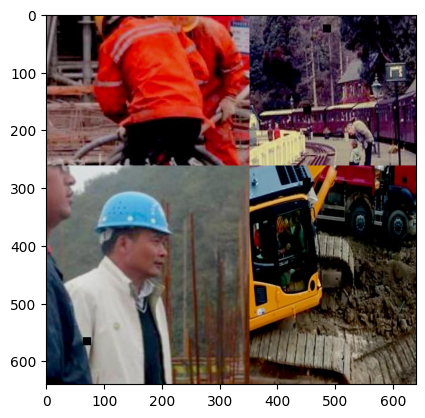

In [ ]:
# Знайомство з даними
# Візуалізуємо одне зображення з набору даних.

def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\\n')
        print('Shape: ', np.array(img).shape, '\\n')

    if hide_axis:
        plt.axis('off')

    plt.show()


example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [ ]:
# Візуалізуємо декілька випадкових зображень з набору даних.

def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [ ]:
# Для подальшої роботи нам треба зберегти основні властивості зображень цього набору даних.

def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:
# Ознайомимося з базовою статистикою датасету. Підрахуємо кількість представників у кожному класі за всіма вибірками.
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


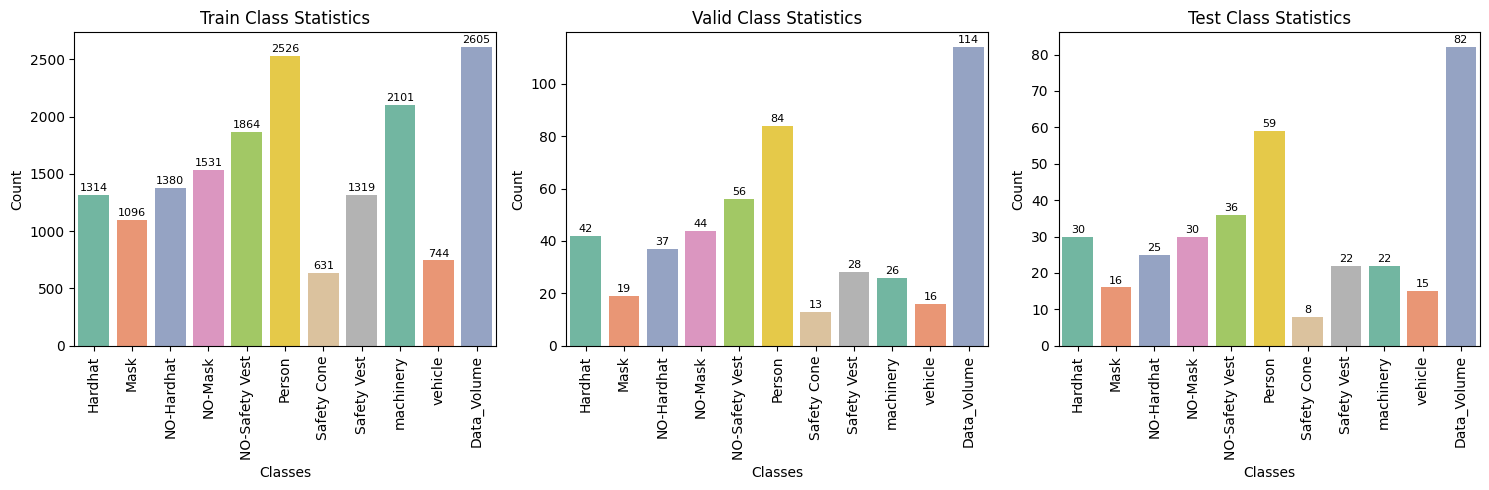

In [ ]:
# Візуалізуємо розподіл класів.
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

Спостерігаємо дисбаланс класів. Нам треба буде врахувати цю особливість під час вибору метрики.

100%|██████████| 112M/112M [00:04<00:00, 24.6MB/s] 



image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 48.6ms
Speed: 4.4ms preprocess, 48.6ms inference, 260.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (640, 640, 3) \n


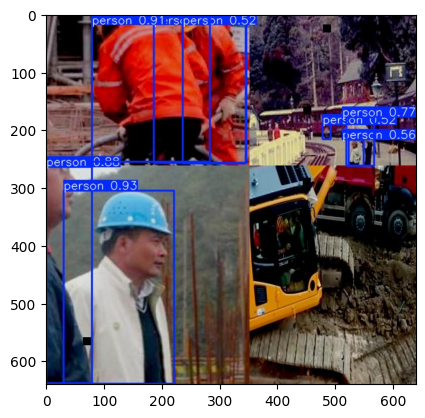

In [ ]:
# Давайте протестуємо попередньо навчену модель YOLOv9 на нашому тестовому прикладі. Для цього створимо об’єкт моделі YOLO та викличемо метод .predict().
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,
    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

Бачимо, що попередньо навчена модель правильно розпізнає клас person.

## Тренування моделі

In [ ]:
# Рекомендовано тренування на kaggle. (Створіть новий ноутбук. Завантажте Jupyter Notebook з репозиторію за допомогою меню у верхньому лівому
# кутку екрану: File -> Import Notebook. У налаштуваннях ноутбука оберіть одну відеокарту. У правому верхньому куті натисніть Save Version.
# Послідкуйте за виконанням 5-10 хвилин і переконайтеся, що весь код виконується без помилок. Виконання коду займе декілька годин.
# Можете, наприклад, поставити код на виконання ввечері й перевірити результати виконання наступного ранку.

# Завантажимо претреновану модель YOLO.
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Для тренування викличемо метод .train нашої моделі.
# З детальним переліком аргументів цього методу можна ознайомитись на офіційній сторінці Ultralytics.

model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0], #  [0,1]
#     device = None, # CPU run
    verbose = False,
)

Ultralytics 8.3.34 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=70, time=None, patience=20, batch=8, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 3.77MB/s]
2024-11-19 17:17:48,996	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-19 17:17:49,203	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.2MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:09<00:00, 268.27it/s]

train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 215.79it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.
Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      12.6G      1.275      1.791      1.517        191        640: 100%|██████████| 326/326 [05:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        114        697      0.477      0.418       0.38       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      12.3G       1.31      1.685      1.545         56        640: 100%|██████████| 326/326 [05:37<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        114        697       0.58      0.417      0.415      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      12.2G      1.292      1.663      1.537        106        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.651      0.471      0.493      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      12.3G       1.26      1.567      1.495         65        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.685      0.508      0.537      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      12.3G      1.209      1.485      1.476        133        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697        0.7      0.526      0.553       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      11.1G      1.188      1.381      1.443         68        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.707      0.556      0.618      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      12.2G      1.146      1.311      1.414        103        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.776      0.565      0.631      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      12.1G      1.122      1.251      1.397        109        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.752      0.595      0.636      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      12.2G      1.099      1.203      1.379        177        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.782      0.614      0.655      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      12.3G      1.084      1.151      1.364        151        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.833      0.609      0.692      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      10.9G      1.064      1.114      1.352         48        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.808      0.615      0.685      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      12.2G      1.042      1.071      1.333        125        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.802      0.623      0.694      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      12.3G      1.034      1.044      1.324        122        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.808      0.655      0.712      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      11.1G      1.019      1.003      1.311         81        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.838      0.639      0.713      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      12.2G      1.003     0.9833      1.305         75        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.841      0.665      0.744      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      12.2G     0.9866     0.9499      1.291        214        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.837      0.638      0.712      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      12.4G     0.9762     0.9281      1.279        123        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.861      0.668      0.743      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      12.3G     0.9567      0.897      1.269        103        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.856      0.664      0.735      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      12.2G      0.942     0.8737      1.262         64        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.811      0.656      0.729      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      12.1G     0.9355     0.8539      1.252        103        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.856       0.69      0.774      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      12.4G     0.9286     0.8251      1.238        134        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.899      0.672      0.759      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      12.2G     0.9076     0.8007      1.225        151        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.875      0.704      0.772       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      12.5G     0.9067     0.7907      1.223        111        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.874      0.727      0.777       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      12.2G     0.8949     0.7843       1.22        128        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.865      0.697      0.775      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      12.4G     0.8774     0.7657      1.211        168        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.835      0.709      0.773      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      12.3G     0.8718     0.7455      1.204         55        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.906      0.703      0.799      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      12.2G     0.8583     0.7293       1.19         79        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.855      0.714      0.793      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      12.2G     0.8461     0.7185      1.184        102        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.896      0.721      0.797      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      12.2G     0.8457     0.7088      1.182         77        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.894      0.722      0.799      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      12.2G     0.8343     0.6948      1.178        139        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.916      0.723      0.818      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      12.3G     0.8298     0.6836      1.175        125        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.871      0.733      0.801      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      12.2G     0.8165     0.6674      1.155         99        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.861      0.761      0.819      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      12.3G     0.7986      0.663      1.156         92        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.866      0.743      0.804      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      12.3G     0.7959     0.6575      1.154        120        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.917      0.739      0.816      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70        11G     0.7836     0.6375      1.146        138        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.886      0.742      0.803      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      12.1G     0.7681     0.6218      1.134        103        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.898      0.765      0.831      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      12.3G     0.7627     0.6112      1.124        109        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.892      0.737      0.813      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      12.2G     0.7557     0.5993      1.122         61        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.898      0.746      0.822      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      12.2G     0.7456     0.5939       1.12        130        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.902      0.782      0.838      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      12.2G     0.7368     0.5744      1.115        143        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.945      0.748       0.84      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      12.4G     0.7409     0.5733      1.111         59        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.908       0.77      0.831      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      12.2G      0.731     0.5701      1.104         88        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.922      0.755      0.842      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      12.4G      0.721     0.5604      1.102        103        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697        0.9      0.801      0.855      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      12.2G     0.7131     0.5532      1.098        108        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.878      0.796      0.838      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      12.4G     0.7039     0.5387      1.087        125        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.911       0.78      0.847      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      12.2G     0.7015     0.5327      1.084        109        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.906      0.787      0.843      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      12.2G     0.6937     0.5312      1.086        108        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.897      0.782       0.85      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      12.2G     0.6816     0.5298      1.086        128        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.898      0.792      0.857      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      12.4G     0.6754     0.5057      1.074         97        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        114        697      0.925      0.774      0.858      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      12.2G     0.6645     0.5004      1.064        125        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.931      0.789       0.86      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      12.2G     0.6575     0.4961      1.061        175        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.926      0.783      0.858       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      12.2G     0.6429     0.4839      1.049         55        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.926      0.794       0.86      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      12.4G     0.6428     0.4801      1.047         83        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.951      0.773       0.86        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      12.4G     0.6431      0.475      1.041        187        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.922      0.815      0.868      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      12.2G     0.6353      0.466      1.039        111        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.939      0.784      0.856      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      12.2G     0.6278     0.4585      1.034         77        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.929       0.81      0.859      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      12.2G     0.6181     0.4538      1.029         90        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.921        0.8      0.858      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      12.2G     0.6156     0.4494      1.029        108        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697       0.93      0.797      0.858      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70        11G      0.603     0.4445      1.027        159        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.948      0.788      0.859      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      12.2G      0.598     0.4383      1.027        120        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697       0.91      0.814      0.866      0.614


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      12.3G     0.5905     0.3711      1.011         47        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.947      0.796      0.871      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      12.2G     0.5759     0.3574     0.9994         50        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.946        0.8      0.867      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      12.3G     0.5632     0.3495     0.9956         65        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697       0.92      0.809      0.869      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      12.2G     0.5526     0.3402     0.9837         52        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.925      0.813      0.872      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      12.2G     0.5512     0.3386      0.982         45        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.917      0.808      0.873      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      12.2G     0.5418     0.3376     0.9849         36        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697      0.913      0.832      0.877      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      12.2G     0.5285     0.3286     0.9725         41        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.916      0.824      0.875      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      12.1G     0.5259     0.3207     0.9702         27        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        114        697       0.91      0.824      0.877      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      12.3G     0.5155     0.3202     0.9649         94        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.957      0.793      0.877      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      12.2G     0.5108     0.3155     0.9579         58        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.947       0.79      0.877      0.635



70 epochs completed in 6.646 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


                   all        114        697      0.947       0.79      0.877      0.635
Speed: 0.2ms preprocess, 35.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a5a8a961840>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [ ]:
# Збережемо ваги натренованої моделі. Для цього використаємо режим експорту.
# У цьому режимі модель перетворюється у формат, який можна використовувати іншими програмними застосунками чи апаратними пристроями.
# Цей режим корисний під час розгортання моделі у виробничих середовищах.
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

# Формат моделі ONNX (Open Neural Network Exchange) — це відкритий стандарт для представлення моделей машинного навчання.
# Він дозволяє переносити моделі між різними фреймворками та інструментами для машинного навчання, такими як PyTorch, TensorFlow тощо,
# забезпечуючи сумісність і спрощуючи інтероперабельність.
# Це дозволяє користувачам тренувати модель в одному середовищі й використовувати її для розгортання в іншому.

Ultralytics 8.3.34 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 6.7s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (15.2s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=640 data=./data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

# Детекція об’єктів. Аналіз результатів

У попередній темі ви натренували модель детекції, тепер вашим завданням є проаналізувати результати її роботи.

In [ ]:
type(results), len(results)

(list, 1)

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9300, 0.9080, 0.8807, 0.7707, 0.5556, 0.5191, 0.5154, 0.3866], device='cuda:0')
data: tensor([[3.0939e+01, 3.0592e+02, 2.2158e+02, 6.3908e+02, 9.3000e-01, 0.0000e+00],
        [7.9768e+01, 8.6823e-02, 2.8355e+02, 2.5599e+02, 9.0799e-01, 0.0000e+00],
        [9.1899e-01, 2.6466e+02, 7.9656e+01, 6.3895e+02, 8.8067e-01, 0.0000e+00],
        [5.1965e+02, 1.7889e+02, 5.6732e+02, 2.6232e+02, 7.7066e-01, 0.0000e+00],
        [5.2302e+02, 2.1735e+02, 5.4946e+02, 2.6224e+02, 5.5556e-01, 0.0000e+00],
        [2.3674e+02, 5.9790e-01, 3.4587e+02, 2.5888e+02, 5.1906e-01, 0.0000e+00],
        [4.7869e+02, 1.9126e+02, 4.9252e+02, 2.1692e+02, 5.1541e-01, 0.0000e+00],
        [1.8614e+02, 9.4513e-02, 3.4673e+02, 2.5728e+02, 3.8655e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([8, 6])
xywh: tensor([[126.2607, 472.

In [ ]:
# YOLO зберігає результати тренування, зокрема різні метрики, у папці runs/detect.
# Збережемо шляхи до всіх зображень з результатами до змінної results_paths.
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

Метрики Average Precision і Mean Average Precision

Average Precision (AP) — це метрика, яка використовується для оцінки ефективності моделей детекції об'єктів. Вона враховує як точність (precision), так і повноту (recall) для обчислення середнього значення точності на різних рівнях порогів впевненості моделі.
Для обчислення AP спочатку будується крива Precision-Recall. Ця крива показує взаємозв'язок між точністю й повнотою при різних порогах впевненості
AP обчислюється як площа під кривою Precision-Recall (PR). Це передбачає виконання таких етапів/кроків:
1. Обчислення точності й повноти для кожного порогу впевненості: усі передбачення сортуються за зменшенням впевненості, для кожного порогу обчислюються значення Precision і Recall.
2. Побудова PR-кривої: на осі X — значення Recall (від 0 до 1), на осі Y — значення Precision (від 0 до 1).
3. Обчислення площі під PR-кривою: використовується, наприклад, метод трапецій для чисельного інтегрування під PR-кривою.


Інтерпретація


AP варіюється від 0 до 1, де 1 — це ідеальна точність (усі передбачення правильні при всіх порогах). Високе значення AP вказує на високу ефективність моделі в детекції об'єктів для даного класу.

Коли йдеться про кілька класів, обчислюють AP для кожного класу окремо, а потім обчислюють середнє значення AP для всіх класів. Так ми отримуємо значення Mean Average Precision:

Однією зі складових результату є розбивка показників продуктивності за класами. Ця детальна інформація корисна, коли ви намагаєтеся зрозуміти, наскільки добре працює модель для кожного конкретного класу, особливо в наборах даних з різноманітними категоріями об’єктів.

Для кожного класу в наборі даних надається така інформація:
- Class: позначає назву класу об’єктів, наприклад, «людина», «автомобіль» або «собака».
- Images: повідомляє про кількість зображень у валідаційних даних, які містять клас об’єктів.
- Instances: надає підрахунок того, скільки разів клас з’являється на всіх зображеннях у валідаційних даних.
- Box(P, R, mAP50, mAP50-95): цей показник дає уявлення про продуктивність моделі при виявленні об’єктів:
 - P (Precision) — точність виявлених об’єктів, яка вказує на кількість правильних виявлень.
 - R (Recall) — здатність моделі ідентифікувати всі екземпляри об’єктів на зображеннях.
 - mAP@50 — Mean Average Precision, розрахована при пороговому значенні перетину через об’єднання (IoU), рівному 0.50. Це показник точності моделі, що враховує лише «легкі» виявлення. Тобто ми будемо вважати, що розпізнали об’єкт, якщо його IoU із ground truth bounding box буде перевищувати 50%.
 - mAP@50-95 — Mean Average Precision, розраховане при зміні порогових значень IoU в діапазоні від 0.50 до 0.95. Він дає повне уявлення про продуктивність моделі на різних рівнях складності виявлення.

./runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


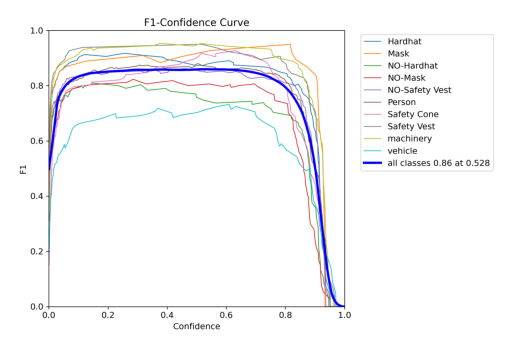



./runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


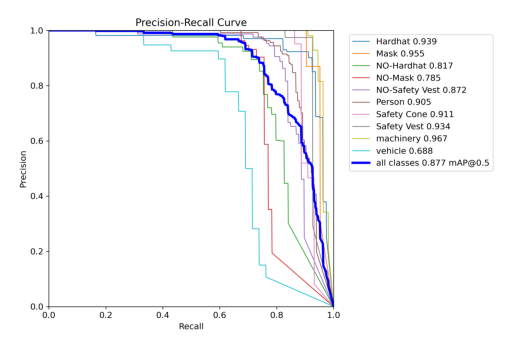



./runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


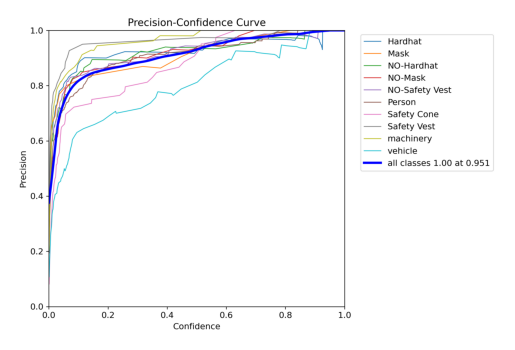



./runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


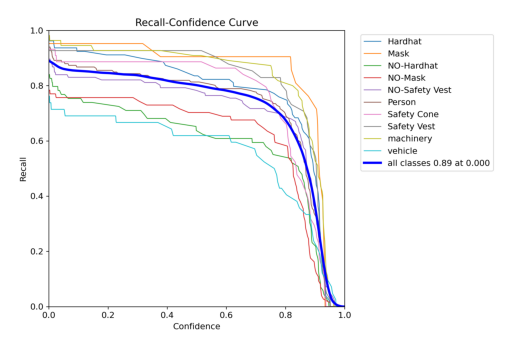



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


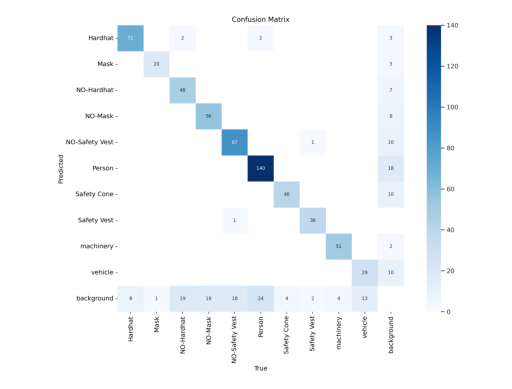



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


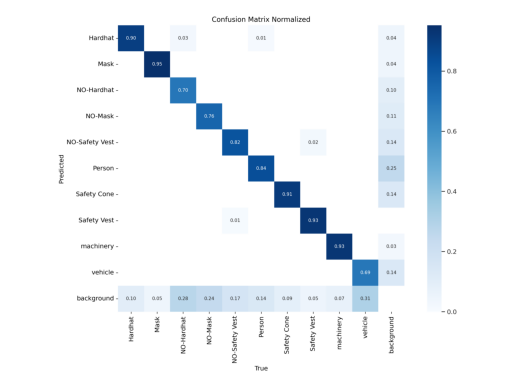



./runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


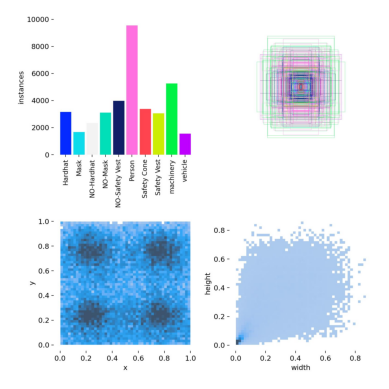



./runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


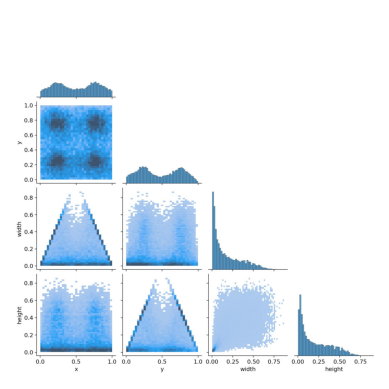



./runs/detect/yolov9e_ppe_css_70_epochs/results.png


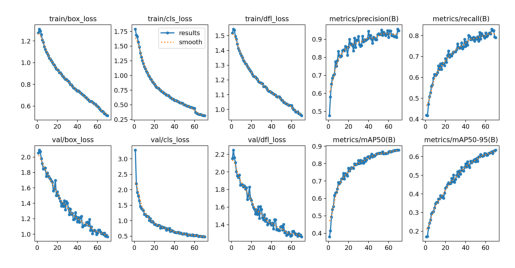

In [ ]:
# Аналіз отриманих результатів
# Переглянемо отримані результати і проаналізуємо їх.

for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

# Ця крива представляє оцінку F1 за різними пороговими значеннями (confidence threshold).
# Наша модель максимізує F1 до 0.87 для всіх класів при пороговому значенні 0.457.
# Тобто якщо ми встановимо threshold впевненості в передбаченні на рівні 0.457, наша модель матиме F1 майже 90%.

# Друга крива демонструє компроміси між Precision і Recall при різних порогах. Це є особливо корисним при роботі з незбалансованими класами.
# Так ми спостерігаємо, що, наприклад, для класу vehicle, який є менш представленим у даних, ми маємо нижче значення mAP@0.5, ніж для інших класів.
# Тому тут може бути доречним використання більшої кількості даних для таких класів або корегування ваг класу під час навчання.
# Середнє mAP@0.5 також є високим — 0.874. Це свідчить про високі значення як Precision, так і Recall.

# Очевидно, що ми максимізуємо Precision при пороговому значені, близькому до 1, а Recall — до 0.

# З confusion matrix ми бачимо, що найчастіше не було розпізнано (тобто було класифіковано як фон) клас vehicle.
# Також бачимо, що класи Safety Vest і Mask іноді були помилково класифіковані як NO-Safety Vest і NO-Mask.

# Ця корелограма дає змогу зрозуміти внутрішню структуру набору даних, що може бути корисним для налаштування моделі або розуміння її продуктивності.
# Верхнє ліве зображення показує кількість кожного класу в наборі даних.
# Верхнє праве зображення показує форми bounding boxes для передбачених класів.
# Два нижні зображення демонструють кореляції між розмірами об’єкта (ширина й висота) або положенням (центр x, центр y) на різних осях

Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

Функція втрат

Функція втрат у YOLO складається з трьох основних компонентів: box loss, class loss і objectness loss (distribution focal loss). Загальна функція втрат YOLO є комбінацією цих трьох компонентів.


- Box loss вимірює, наскільки точно прогнозовані координати обмежувальної рамки (bounding boxes) відповідають правдивим обмежувальним рамкам (ground truth).
Зазвичай обчислюється за допомогою функції втрат для задач регресії, наприклад, середньоквадратичної помилки (MSE) між передбачуваними координатами обмежувальної рамки (координати центру, ширина й висота) і координатами ground truth обмежувальної рамки.
- Class loss (Втрата класу) вимірює, наскільки добре прогнозовані ймовірності класу відповідають справжнім міткам класу.
Втрата класу зазвичай обчислюється за допомогою categorical cross-entropy loss, яка «штрафує» різницю між прогнозованими ймовірностями класу та справжніми мітками класу.
- Objectness loss/Distribution focal loss YOLO передбачає оцінку «об’єктності» для кожної обмежувальної рамки, що вказує на присутність об’єкта у клітинці сітки. Ця оцінка допомагає відфільтрувати нерелевантні обмежувальні рамки.
Функція втрат об’єктності розраховується на основі різниці між прогнозованим показником об’єктності та реальною міткою об’єктності. Вона «карає» модель за хибні позитивні та хибні негативні результати при прогнозуванні присутності об’єкта.

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,367.829,1.27466,1.79102,1.51710,0.47650,0.41837,0.38003,0.17000,2.05362,3.28209,2.15012,0.000237,0.000237,0.000237
1,2,713.217,1.31017,1.68542,1.54474,0.58026,0.41653,0.41460,0.17163,2.09032,2.19661,2.24769,0.000469,0.000469,0.000469
2,3,1056.370,1.29234,1.66268,1.53684,0.65090,0.47103,0.49283,0.21866,2.07077,1.91279,2.16382,0.000693,0.000693,0.000693
3,4,1398.610,1.26003,1.56692,1.49482,0.68524,0.50811,0.53704,0.24354,1.97921,1.80107,2.10526,0.000684,0.000684,0.000684
4,5,1740.920,1.20949,1.48505,1.47623,0.70012,0.52642,0.55319,0.26001,1.91626,1.64813,2.00255,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,22557.700,0.54180,0.33756,0.98488,0.91305,0.83153,0.87686,0.62640,0.99383,0.49862,1.27035,0.000058,0.000058,0.000058
66,67,22898.900,0.52854,0.32863,0.97254,0.91623,0.82373,0.87470,0.61775,1.01373,0.49463,1.29711,0.000048,0.000048,0.000048
67,68,23239.400,0.52594,0.32070,0.97021,0.90961,0.82417,0.87716,0.63086,0.97198,0.48106,1.27519,0.000037,0.000037,0.000037
68,69,23580.500,0.51552,0.32022,0.96491,0.95655,0.79317,0.87729,0.63076,0.98755,0.49119,1.28248,0.000027,0.000027,0.000027


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.51082 , on epoch:  70 


Best Validation Box loss:  0.96588 , on epoch:  70 


Best Training Cls loss:  0.31548 , on epoch:  70 


Best Validation Cls loss:  0.48106 , on epoch:  68 


Best Training DFL loss:  0.95793 , on epoch:  70 


Best Validation DFL loss:  1.26298 , on epoch:  70 



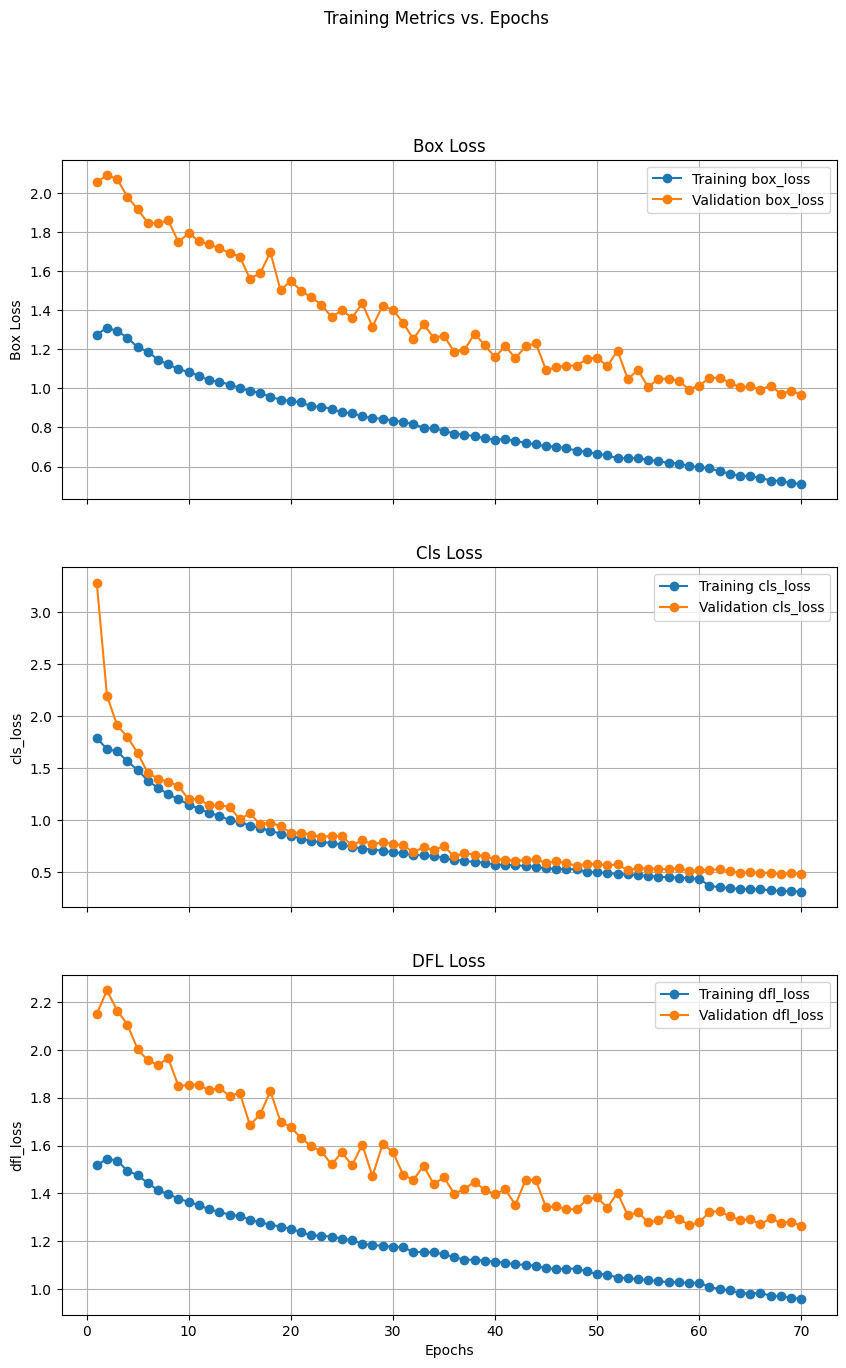

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [ ]:
# Розглянемо приклади детекції на валідаційному наборі даних.
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov9e_ppe_css_70_epochs/val_batch2_labels.jpg


./runs/detect/yolov9e_ppe_css_70_epochs/val_batch2_labels.jpg


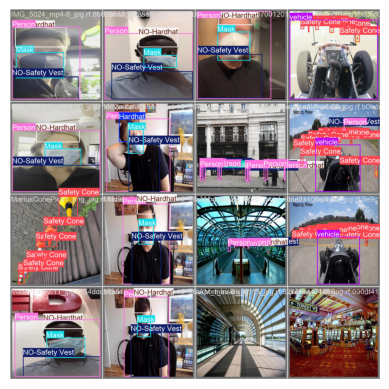

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

Ми бачимо, що модель розпізнає екземпляри класів, які ми використали для тренування, і не генерує хибно позитивних міток класів там, де люди не присутні на зображенні.